# Questão 1

A representação de uma determinada mensagem digital ternária, isto é formada por três bits,
forma um cubo cujos vértices correspondem a mesma representação digital. Supondo que ao
transmitirmos esta mensagem a mesma possa ser contaminada por ruído formado em torno de
cada vértice uma nuvem esférica de valores aleatórios com raio máximo é 0.1. Formule este
problema como um problema de classificação de padrões e treine uma rede Perceptron de
Rosenblatt (Perceptron de camada única) para atuar como classificador/decodificador. Para
solução do problema defina antes um conjunto de treinamento e um conjunto de validação.

## Importação

Importando as bibliotecas que serão usadas para resolver o problema.

In [2]:
# Biblioteca para funções estatísticas matemáticas
import statistics as st

# Biblioteca que possui funções para manipulação numérica de arrays e matrizes
import numpy as np

# Biblioteca para plotagem e manipulação de gráficos
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

## Funções de ativação

Funções de ativação que a rede usará para forçar que sua saída represente a probabilidade dos dados serem de uma das classes definidas.

In [3]:
# Implementação da função de ativação linear
def linear(x):
    return np.ones_like(x) if derivative else x

# Implementação da função de ativação sigmoid
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

# Implementação da função de ativação degrau
def step(x):
    return np.where(x>0,1,-1)

## Função de plotagem

Função usada para gerar o gráfico de épocas vs erros.

In [4]:
def plot_error(data=[], label=['', ''], color=['blue', 'red']):
    plt.title("Erro treino x validação")
    plt.xlabel("epocas")
    plt.ylabel("erros")
    plt.legend(handles=[mpatches.Patch(color=color[0], label=label[0]),
                        mpatches.Patch(color=color[1], label=label[1])])
    plt.plot(data[0], c=color[0])
    plt.plot(data[1], c=color[1])
    plt.show()

## Classe de Camada

Classe que representará uma camada da rede que guardará os parâmetros de entrada.

### Parâmetros 

* **dimensao**: dimensão dos dados de entrada da camada;
* **quant**: quantidade de neurônios da camada;
* **func**: função de ativação que será utilizada nos neurônios da rede;

### Atributos

* **x**: dados de entrada da camada;
* **w**: matriz todos os pesos de todos os neurônios da camada;
* **bias**: vetor com os valores dos bias de todos os neurônios da camada;
* **func**: função de ativação que será utilizada nos neurônios da rede;
* **saidaFunc**: armazena saída da função de ativação;

In [5]:
class Camada():
    def __init__(self, dimensao, quant=1, func=step):
        self.x = None
        self.w = np.random.randn(quant, dimensao)
        self.bias = np.random.randn(1, quant)
        self.func = func
        self.saidaFunc = None

## Classe RedeNeural

Classe que representará a Rede Neural.

### Atributos

* **camadas**: conjunto de camadas da rede;

In [13]:
class RedeNeural():
    def __init__(self):
        self.camadas = []
        
    def treinar(self, x, y, x_valid, y_valid, learning_rate=1e-3, epochs=100, verbose=10, plot=False):
        '''
            Função de treinamento
            Parâmetros:
                x - entradas
                y - saídas esperadas
                learning_rate - taxa de aprendizagem
                epochs - quantidade de épocas de treinamento
                verbose - passos para verificação da época
        '''
        errors_train = []
        errors_valid = []

        for epoch in range(epochs+1):
            error_epoch = []
            for x_i, y_i in zip(x, y):
                x_i =  x_i.reshape(1, x.shape[1])
                y_pred = self.processaNeuronio(x_i)
                
                # erro de treinamento
                erro = y_i - y_pred
                error_epoch.append(np.mean(np.abs(erro[0])))
                
                for camada in self.camadas:
                    camada.w += learning_rate * np.dot(erro.T, x_i)
                    camada.bias += learning_rate * erro[0]
            
            # calculo do erro de predição
            y_pred = self.previsao(x_valid)
            acc = self.validar(y_pred, y_valid)
            errors_valid.append(1 - acc)
            errors_train.append(np.mean(error_epoch))
            
            if epoch % verbose == 0:
                print("epoch: {0:=4}/{1}\nerror: {2}".format(epoch, epochs, errors_train[-1]))
                
        print("Acuracia =", acc)
            
        return errors_train, errors_valid
    
    def adicionaCamada(self, camada):
        '''
            Método para adição de camadas ao modelo
            Parâmetros:
                camada - Camada para adicionar ao modelo
        '''
        self.camadas.append(camada)
    
    def processaNeuronio(self, x):
        '''
            Método de processamento - Efetua a multiplicação das entradas pelos pesos, soma ao bias, aplica função de ativação
            Parâmetros:
                x - dados de entrada
        '''
        self.camadas[0].x = x
        for current_layer, next_layer in zip(self.camadas, self.camadas[1:]+[Camada(0,0)]):
            y = np.dot(current_layer.x, current_layer.w.T) + current_layer.bias
            current_layer.saidaFunc = next_layer.x = current_layer.func(y)
        return self.camadas[-1].saidaFunc
    
    def previsao(self, x):
        '''
            Método de Predição - Gera um conjunto de valores resultante do processo de FeedForward nos para os dados de entrada
            Parâmetros:
                x - dados de entrada
        '''
        y_pred = []
        
        for data in x:
            y_pred.append(self.processaNeuronio(data))
            
        return np.array(y_pred)
    
    def validar(self,y_pred, y, dtype=int):
        '''
            Método Validar - Verifica a acurácia da rede
            Parâmetros:
                y_pred - resultado do processo de ProcessaNeuronio sobre os dados de entrada
                dtype - tipo dos dados
        '''
        score = 0
        #total = 100.0/y.shape[0]
        total = 1/y.shape[0]

        # verifica se possuem o tipo de saída esperado
        y_pred = y_pred.astype(dtype)
        y = y.astype(dtype)

        for y_i, y_pred_i in zip(y,y_pred):
            if np.array_equal(y_i,y_pred_i[0]):
                score+=1

        return score*total

## Fluxo de execução da Main

Representará a inicialização e execução da rede neural.

**Fluxo**: A rede será inicializada, os dados de entrada e saída serão obtidos, o treinamento será feito e a acuarácia será verificada.

epoch:    0/40
error: 0.98125
epoch:   10/40
error: 0.38671875
epoch:   20/40
error: 0.22578125
epoch:   30/40
error: 0.08984375
epoch:   40/40
error: 0.0109375
Acuracia = 0.9375


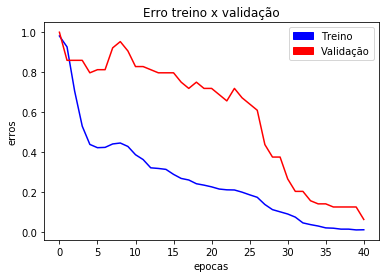

In [20]:
rn = RedeNeural()

x = []
y = []

# leitura dos dados
for line in open('./data_x.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('./data_y.txt', 'r').readlines():
    y.append([int(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

rn.adicionaCamada(Camada(dimensao=x.shape[1], quant=y.shape[1], func=step))

# treinamento
errors_train, errors_valid = rn.treinar(x, y, x_valid, y_valid, learning_rate=0.001 , epochs=40, verbose=10, plot=True)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])